In [ ]:

!pip install -q scipy torch torchvision matplotlib scikit-learn

Data shape: (100, 100, 204)
GT shape: (100, 100)


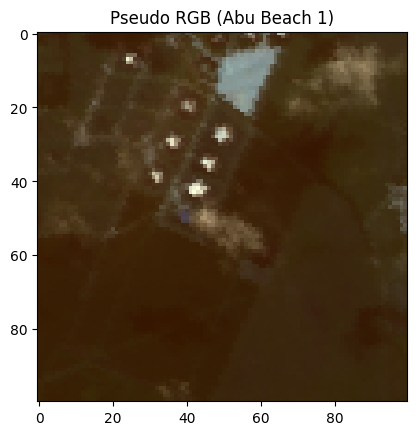

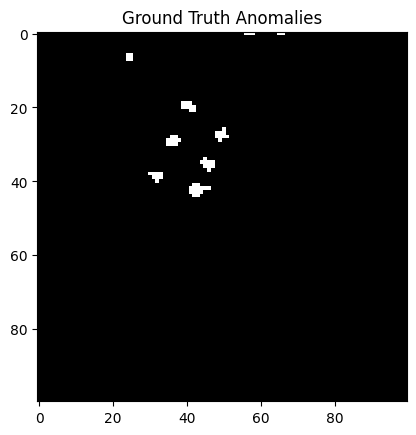

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt


mat = sio.loadmat("/content/abu-urban-1.mat")
data = mat['data']
gt = mat['map']

print("Data shape:", data.shape)
print("GT shape:", gt.shape)

#pseudo RGB
rgb = data[:,:,[10,20,30]]
rgb = (rgb - rgb.min()) / (rgb.max()-rgb.min())
plt.imshow(rgb)
plt.title("Pseudo RGB (Abu Beach 1)")
plt.show()

#ground truth
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth Anomalies")
plt.show()

Epoch 1/25, Loss = 1.006947
Epoch 6/25, Loss = 0.900607
Epoch 11/25, Loss = 0.629593
Epoch 16/25, Loss = 0.415319
Epoch 21/25, Loss = 0.298809
Epoch 25/25, Loss = 0.250684


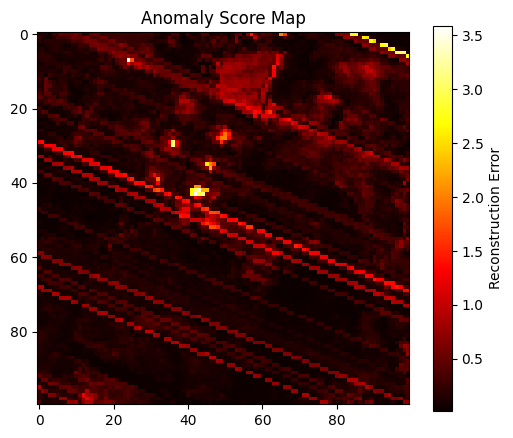

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

H, W, B = data.shape
X = data.reshape(-1, B)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)

class AE(nn.Module):
    def __init__(self, bands):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(bands, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, bands)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


model = AE(B)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


epochs = 25
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.6f}")


with torch.no_grad():
    recon = model(X_tensor).numpy()
errors = np.mean((X - recon)**2, axis=1)
anom_map = errors.reshape(H, W)


plt.figure(figsize=(6,5))
plt.imshow(anom_map, cmap="hot")
plt.colorbar(label="Reconstruction Error")
plt.title("Anomaly Score Map")
plt.show()

Device: cuda
Extracting patches (this can be memory heavy)...
Patches shape: (10000, 204, 7, 7) Centers shape: (10000, 204)
Training model...
Epoch 1/40  Avg Loss: 2.101093
Epoch 5/40  Avg Loss: 0.973457
Epoch 10/40  Avg Loss: 0.805886
Epoch 15/40  Avg Loss: 0.730242
Epoch 20/40  Avg Loss: 0.657562
Epoch 25/40  Avg Loss: 0.601629
Epoch 30/40  Avg Loss: 0.547721
Epoch 35/40  Avg Loss: 0.538581
Epoch 40/40  Avg Loss: 0.505000


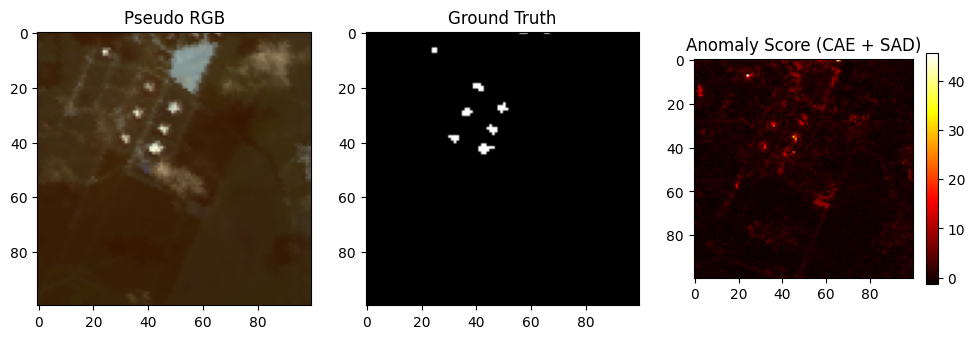

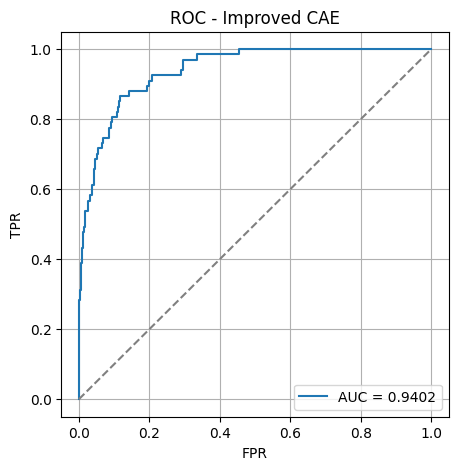

AUC (CAE + SAD): 0.940196330338642


In [ ]:

import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

patch_size = 7
bands = data.shape[2]
H, W = data.shape[0], data.shape[1]
batch_size = 1024
epochs = 40
lr = 1e-3
noise_std = 0.01
lambda_sad = 1.0



def extract_patches_and_centers(hsi, patch_size):
    pad = patch_size // 2
    padded = np.pad(hsi, ((pad,pad),(pad,pad),(0,0)), mode='reflect')
    patches = []
    centers = []
    # iterate pixels
    for i in range(pad, pad+H):
        for j in range(pad, pad+W):
            patch = padded[i-pad:i+pad+1, j-pad:j+pad+1, :]  # (px,px,bands)
            # reorder channels for conv: (bands, px, px)
            patch = np.transpose(patch, (2,0,1)).astype(np.float32)
            center = padded[i,j,:].astype(np.float32)
            patches.append(patch)
            centers.append(center)
    patches = np.stack(patches, axis=0)   # (N, bands, px, px)
    centers = np.stack(centers, axis=0)   # (N, bands)
    return patches, centers

print("Extracting patches (this can be memory heavy)...")
patches, centers = extract_patches_and_centers(data, patch_size)
N = patches.shape[0]
print("Patches shape:", patches.shape, "Centers shape:", centers.shape)


band_means = centers.mean(axis=0, keepdims=True)
band_stds  = centers.std(axis=0, keepdims=True) + 1e-6
centers_norm = (centers - band_means) / band_stds

patches_norm = (patches - band_means[:,:,None,None]) / band_stds[:,:,None,None]


patches_t = torch.tensor(patches_norm, dtype=torch.float32, device=device)
centers_t = torch.tensor(centers_norm, dtype=torch.float32, device=device)


indices = np.arange(N)


class PatchCAE(nn.Module):
    def __init__(self, bands, patch_size, latent_dim=64):
        super().__init__()
        els
        self.enc = nn.Sequential(
            nn.Conv2d(bands, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc1 = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, bands)
    def forward(self, x):

        h = self.enc(x)
        h = h.view(h.size(0), -1)
        z = self.fc1(h)
        out = self.fc2(z)
        return out

model = PatchCAE(bands=bands, patch_size=patch_size, latent_dim=64).to(device)
opt = optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss()


def spectral_angle_loss(x, y):

    eps = 1e-8
    dot = torch.sum(x*y, dim=1)
    nx = torch.norm(x, dim=1)
    ny = torch.norm(y, dim=1)
    cos = dot / (nx*ny + eps)
    cos = torch.clamp(cos, -1+1e-7, 1-1e-7)
    angle = torch.acos(cos)
    return torch.mean(angle)


print("Training model...")
for epoch in range(epochs):
    model.train()

    perm = np.random.permutation(N)
    running_loss = 0.0
    steps = 0
    for start in range(0, N, batch_size):
        batch_idx = perm[start:start+batch_size]
        xb = patches_t[batch_idx]
        yb = centers_t[batch_idx]

        noise = torch.randn_like(xb) * noise_std
        xb_noisy = xb + noise
        opt.zero_grad()
        pred = model(xb_noisy)
        loss_mse = mse_loss(pred, yb)
        loss_sad = spectral_angle_loss(pred, yb)
        loss = loss_mse + lambda_sad * loss_sad
        loss.backward()
        opt.step()
        running_loss += loss.item()
        steps += 1
    avg_loss = running_loss / steps
    if (epoch+1) % 5 == 0 or epoch==0 or epoch==epochs-1:
        print(f"Epoch {epoch+1}/{epochs}  Avg Loss: {avg_loss:.6f}")


model.eval()
with torch.no_grad():
    preds = []
    for start in range(0, N, batch_size):
        idx = np.arange(start, min(start+batch_size, N))
        xb = patches_t[idx]
        p = model(xb)
        preds.append(p.cpu().numpy())
    preds = np.vstack(preds)


preds_denorm = preds * band_stds + band_means
centers_orig = centers

mse_scores = np.mean((preds_denorm - centers_orig)**2, axis=1)


dot = np.sum(preds_denorm * centers_orig, axis=1)
n1 = np.linalg.norm(preds_denorm, axis=1)
n2 = np.linalg.norm(centers_orig, axis=1)
cos = np.clip(dot / (n1*n2 + 1e-12), -1+1e-12, 1-1e-12)
angles = np.arccos(cos)
angles_deg = angles * 180.0 / np.pi


from scipy import stats
mse_z = stats.zscore(mse_scores)
ang_z = stats.zscore(angles_deg)
combined = mse_z + ang_z

anom_map_new = combined.reshape(H, W)


plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
rgb = data[:,:,[10,20,30]]
rgb = (rgb - rgb.min())/(rgb.max()-rgb.min())
plt.imshow(rgb); plt.title("Pseudo RGB")
plt.subplot(1,3,2)
plt.imshow(gt, cmap='gray'); plt.title("Ground Truth")
plt.subplot(1,3,3)
plt.imshow(anom_map_new, cmap='hot'); plt.title("Anomaly Score (CAE + SAD)")
plt.colorbar(shrink=0.6)
plt.show()


y_true = gt.flatten()
y_score = anom_map_new.flatten()
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Improved CAE")
plt.legend(); plt.grid(True)
plt.show()
print("AUC (CAE + SAD):", roc_auc)

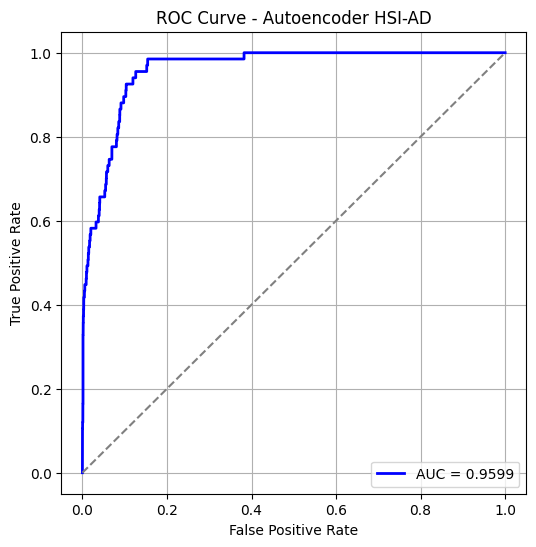

ROC AUC Score: 0.9599


In [ ]:

from sklearn.metrics import roc_curve, auc


y_true = gt.flatten()
y_score = anom_map.flatten()


fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Autoencoder HSI-AD")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

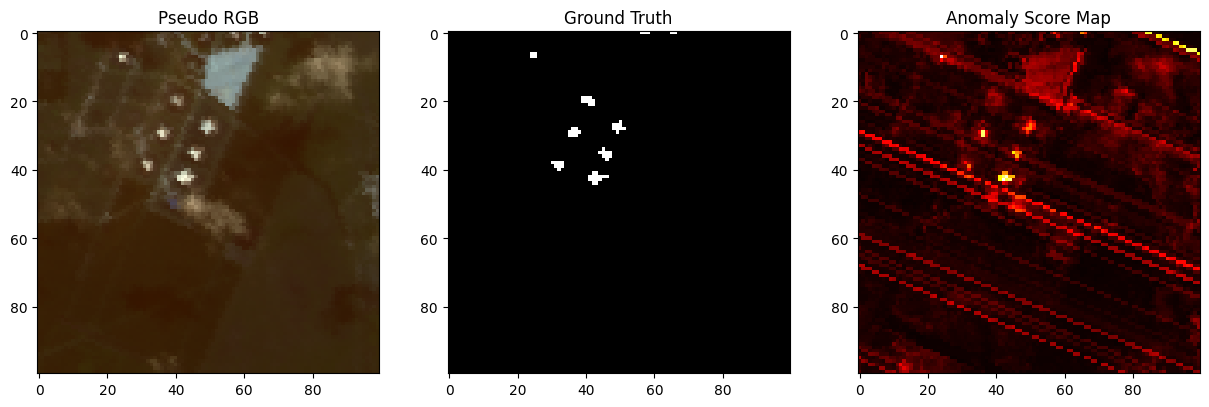

In [ ]:


plt.figure(figsize=(15,5))

rgb = data[:,:,[10,20,30]]
rgb = (rgb - rgb.min()) / (rgb.max()-rgb.min())

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Pseudo RGB")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(anom_map, cmap="hot")
plt.title("Anomaly Score Map")

plt.show()